<a href="https://colab.research.google.com/github/ImpurestPath/nn-sem6/blob/master/Epilepsy_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

!wget -c http://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv


--2020-05-13 15:50:36--  http://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
from collections import namedtuple
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
# %load_ext ipycache
from torchvision import transforms

In [0]:
df = pd.read_csv("data.csv")

In [0]:
df.head(5)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [0]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,-5.827478,-6.042174,-6.687304,-7.088870,-7.211217,-7.088261,-6.806696,-6.744696,-6.484783,-6.448435,-6.355391,-6.543130,-6.884348,-6.883217,-6.118870,-5.15913,-4.785652,-4.874783,-5.393565,-5.935478,-6.349913,-6.212522,-5.859826,-5.299826,-4.955652,-5.278087,-6.162261,-7.316609,-7.998522,-7.818870,...,-6.997304,-7.339391,-7.911565,-8.177304,-8.608870,-8.578087,-8.240000,-7.691391,-7.356522,-7.228783,-6.980870,-6.756783,-6.355304,-6.423826,-6.465217,-6.316435,-5.808000,-5.255913,-4.682087,-4.638609,-4.770261,-5.650870,-7.170348,-8.759826,-9.784783,-10.096261,-9.842957,-9.701739,-9.351391,-9.498870,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,3.000000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,160.471017,161.181118,165.071121,169.198359,170.641967,168.930355,164.646296,162.062661,162.571333,162.339911,162.823325,163.909723,165.844176,166.009100,164.715153,162.77423,162.902294,164.799831,165.391697,164.291120,163.165167,163.408052,163.561408,162.548119,160.813772,160.441049,162.881958,166.235164,166.314965,164.513017,...,168.567495,168.662705,167.643458,167.414439,167.922773,168.274009,167.808218,166.739558,165.678558,167.130911,168.156296,167.459868,165.061414,164.248830,166.226332,168.143625,167.067064,166.446540,167.554020,169.418457,170.639171,170.817824,168.145372,166.817974,166.999981,167.756860,166.988820,167.062497,166.606345,165.235574,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,1.414275
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,-1765.000000,-1803.000000,-1833.000000,-1867.000000,-1870.000000,-1839.000000,-1867.000000,-1856.000000,-1844.000000,-1717.000000,-1764.000000,-1856.000000,-1844.000000,-1866.000000,-1863.000000,-1866.00000,-1781.000000,-1860.000000,-1818.000000,-1867.000000,-1743.000000,-1517.000000,-1552.000000,-1720.000000,-1864.000000,-1814.000000,-1829.000000,-1851.000000,-1840.000000,-1673.000000,...,-1867.000000,-1826.000000,-1866.000000,-1854.000000,-1789.000000,-1872.000000,-1866.000000,-1675.000000,-1778.000000,-1733.000000,-1862.000000,-1861.000000,-1857.000000,-1839.000000,-1860.000000,-1843.000000,-1863.000000,-1861.000000,-1845.000000,-1820.000000,-1864.000000,-1868.000000,-1855.000000,-1852.000000,-1870.000000,-1847.000000,-1578.000000,-1838.000000,-1763.0000

In [0]:
df.columns

Index(['Unnamed: 0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       ...
       'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178',
       'y'],
      dtype='object', length=180)

In [0]:
df.rename(columns={'Unnamed: 0': 'Text'},inplace=True)

In [0]:
df.columns=df.columns.str.replace('X','')

In [0]:
df.columns

Index(['Text', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '170', '171', '172', '173', '174', '175', '176', '177', '178', 'y'],
      dtype='object', length=180)

In [0]:
def plot_eeg_values(axis, values):
  axis.plot(range(1,len(values)+1),values)
  axis.set_ylabel('uV')
  axis.set_xlabel('timepoint')  


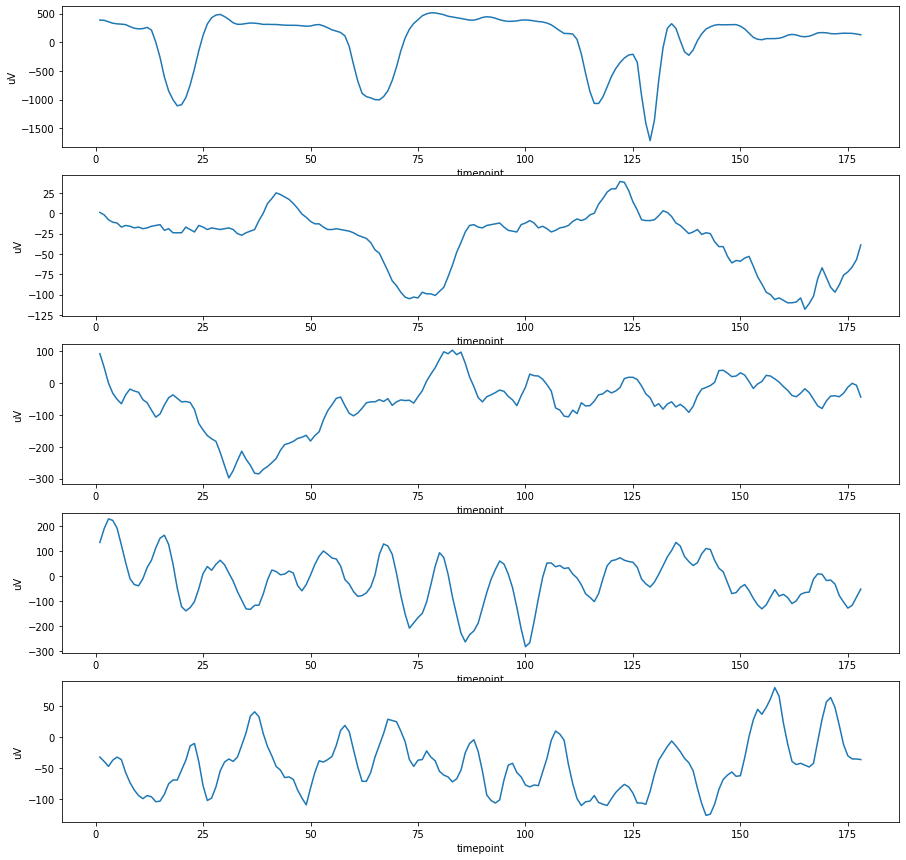

In [0]:
fig, axs = plt.subplots(nrows=5,figsize=(15,15))

plot_eeg_values(axs[0], df[df['y'] == 1].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[1], df[df['y'] == 2].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[2], df[df['y'] == 3].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[3], df[df['y'] == 4].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[4], df[df['y'] == 5].loc[:, '1':'178'].iloc[0].values)

In [0]:
abs(df[df['y'] == 1].loc[:, '1':'178'].iloc[0].values.max())

513

In [0]:
df.drop('Text', axis=1, inplace=True)

In [0]:
df.loc[:,'1':'178'] = df.apply((lambda x:  (x['1':'178'] / (abs(x.values.max()) if abs(x.values.max()) > abs(x.values.min()) else abs(x.values.min())))), axis=1)

In [0]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-0.051559,-0.049830,-0.049584,-0.049635,-0.049973,-0.051027,-0.052422,-0.054239,-0.054347,-0.054743,-0.054140,-0.053710,-0.052321,-0.050206,-0.047928,-0.045804,-0.043344,-0.042726,-0.041682,-0.041854,-0.042364,-0.043191,-0.044550,-0.045796,-0.044654,-0.042143,-0.038867,-0.036521,-0.035735,-0.036905,-0.038919,-0.039270,-0.039096,-0.038269,-0.037694,-0.037656,-0.038763,-0.041330,-0.042929,-0.043432,...,-0.051740,-0.053693,-0.055908,-0.055971,-0.056404,-0.056990,-0.057554,-0.056824,-0.056288,-0.054730,-0.052031,-0.048730,-0.045373,-0.044058,-0.043506,-0.043453,-0.042857,-0.042355,-0.042232,-0.041792,-0.041949,-0.043299,-0.046362,-0.050261,-0.053411,-0.055216,-0.054956,-0.054819,-0.053778,-0.053867,-0.055280,-0.058383,-0.060681,-0.061924,-0.060869,-0.059220,-0.057301,-0.055812,-0.054507,3.000000
std,0.409274,0.410037,0.409236,0.408210,0.406938,0.407967,0.408595,0.408515,0.407591,0.406624,0.406005,0.405861,0.406457,0.407899,0.409300,0.408384,0.406215,0.404918,0.406499,0.408889,0.409709,0.408225,0.407692,0.406128,0.405548,0.404689,0.404057,0.403664,0.402094,0.400584,0.400285,0.402601,0.404631,0.405867,0.405626,0.403890,0.404089,0.405611,0.404151,0.402535,...,0.405865,0.405027,0.405232,0.407118,0.408075,0.408787,0.407228,0.405896,0.403728,0.402968,0.403558,0.405109,0.405222,0.405239,0.403479,0.402107,0.401202,0.400078,0.398932,0.398559,0.399052,0.400634,0.401026,0.400152,0.400212,0.401924,0.403444,0.404601,0.404505,0.403659,0.402217,0.401439,0.402517,0.402735,0.402492,0.401327,0.403162,0.405046,0.407727,1.414275
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,-0.325026,-0.327869,-0.330079,-0.330214,-0.330205,-0.331540,-0.336213,-0.336788,-0.337818,-0.333333,-0.333333,-0.333333,-0.333333,-0.330752,-0.328061,-0.322245,-0.321784,-0.317487,-0.324381,-0.328079,-0.326859,-0.328125,-0.330709,-0.329372,-0.326241,-0.312500,-0.311945,-0.311018,-0.308989,-0.311688,-0.314087,-0.316892,-0.319480

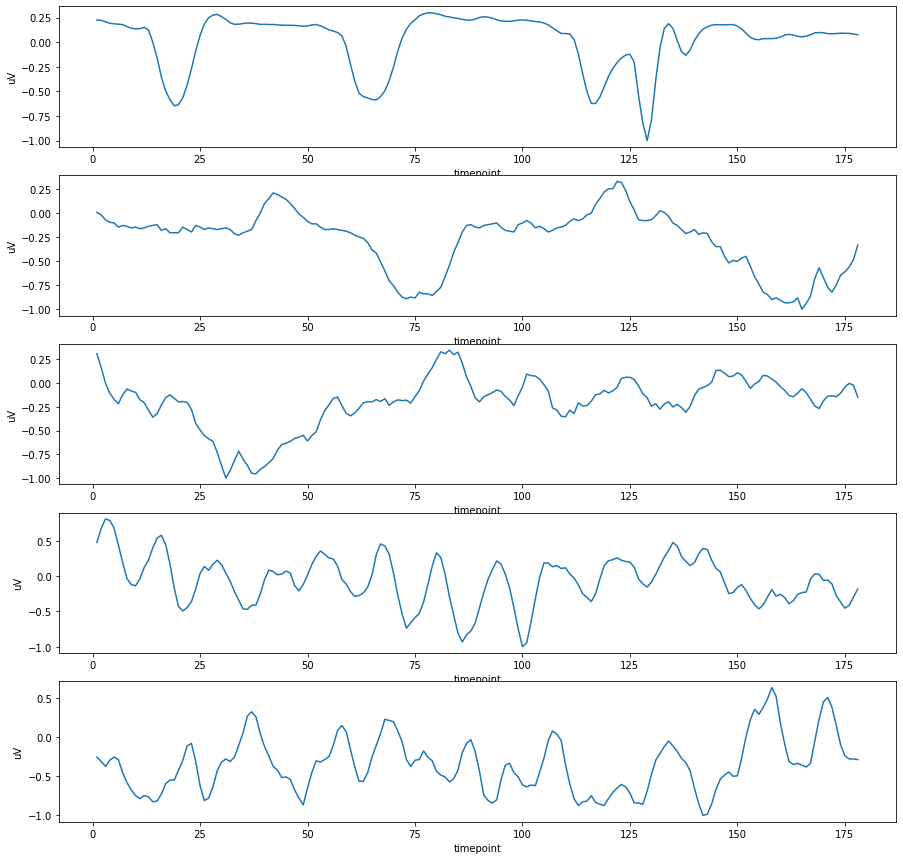

In [0]:
fig, axs = plt.subplots(nrows=5,figsize=(15,15))

plot_eeg_values(axs[0], df[df['y'] == 1].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[1], df[df['y'] == 2].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[2], df[df['y'] == 3].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[3], df[df['y'] == 4].loc[:, '1':'178'].iloc[0].values)
plot_eeg_values(axs[4], df[df['y'] == 5].loc[:, '1':'178'].iloc[0].values)

In [0]:
df[df['y'] == 1].shape[0]

2300

In [0]:
np.random.shuffle(df.values)
first = df[df['y'] == 1]
number_of_samples = int(first.shape[0] / 4)
second = df[df['y'] == 2].iloc[:number_of_samples]
third  = df[df['y'] == 3].iloc[:number_of_samples]
fourth = df[df['y'] == 4].iloc[:number_of_samples]
fifth = df[df['y'] == 5].iloc[:number_of_samples]
data = pd.concat([first,second,third,fourth,fifth])

In [0]:
np.random.shuffle(data.values)
labels = data['y'].values
labels = labels == 1
data = data.loc[:, '1':'178'].values


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)


print(X_train.shape)

(2944, 178)


In [0]:
batch_size = 25

trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(2), torch.from_numpy(y_train.astype('long')))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = TensorDataset(torch.from_numpy(X_valid.astype('float32')).unsqueeze(2), torch.from_numpy(y_valid.astype('long')))
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = TensorDataset(torch.from_numpy(X_test.astype('float32')).unsqueeze(2), torch.from_numpy(y_test.astype('long')))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [0]:
class RcNN(nn.Module):
    def __init__(self):
        super(RcNN, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=48, num_layers=2, batch_first=True, dropout=0.05)
        # self.rnn = nn.LSTM(input_size=1, hidden_size=16, num_layers=2, batch_first=True, dropout=0.4)
        self.fc = nn.Linear(in_features=48, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=2)


    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        x = self.fc2(x)
        return x


model = RcNN()
device = torch.device("cuda:0") # Let's make sure GPU is available!
model.type(torch.cuda.FloatTensor)
model.to(device)

RcNN(
  (rnn): GRU(1, 48, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=48, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [0]:


loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 5, 0.1)


In [0]:

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
  loss_history = []
  train_history = []
  val_history = []
  for epoch in range(num_epochs):
      model.train() # Enter train mode
      
      loss_accum = 0
      correct_samples = 0
      total_samples = 0
      for i_step, (x, y) in enumerate(train_loader):
          x_gpu = x.to(device)
          y_gpu = y.to(device)
          prediction = model(x_gpu)    
          loss_value = loss(prediction, y_gpu)
          optimizer.zero_grad()
          loss_value.backward()
          optimizer.step()
          
          _, indices = torch.max(prediction, 1)
          correct_samples += torch.sum(indices == y_gpu)
          total_samples += y.shape[0]
          
          loss_accum += loss_value

      ave_loss = loss_accum / i_step
      train_accuracy = float(correct_samples) / total_samples
      val_accuracy = compute_accuracy(model, val_loader)

      if scheduler != None:
        scheduler.step()
      loss_history.append(float(ave_loss))
      train_history.append(train_accuracy)
      val_history.append(val_accuracy)
      
      print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
      
  return loss_history, train_history, val_history

def compute_accuracy(model, loader):
  """
  Computes accuracy on the dataset wrapped in a loader

  Returns: accuracy as a float value between 0 and 1
  """
  model.eval() # Evaluation mode
  truth = 0.0
  n = 0
  for x, y  in loader:
    x_device = x.to(device)
    y_device = y.to(device)
    preds = model(x_device)
    truth += sum(preds.argmax(1) == y_device)
    n += y_device.shape[0]
  return truth / n

loss_history, train_history, val_history = train_model(model, trainloader, validloader, loss, optimizer, 20, scheduler)

Average loss: 0.702187, Train accuracy: 0.531250, Val accuracy: 0.548913
Average loss: 0.616453, Train accuracy: 0.663383, Val accuracy: 0.705163
Average loss: 0.493158, Train accuracy: 0.772758, Val accuracy: 0.789402
Average loss: 0.333443, Train accuracy: 0.853601, Val accuracy: 0.903533
Average loss: 0.232185, Train accuracy: 0.912704, Val accuracy: 0.930707
Average loss: 0.144164, Train accuracy: 0.947011, Val accuracy: 0.941576
Average loss: 0.118426, Train accuracy: 0.959239, Val accuracy: 0.947011
Average loss: 0.106256, Train accuracy: 0.962976, Val accuracy: 0.941576
Average loss: 0.100925, Train accuracy: 0.963995, Val accuracy: 0.947011
Average loss: 0.090840, Train accuracy: 0.965353, Val accuracy: 0.948370
Average loss: 0.074356, Train accuracy: 0.975543, Val accuracy: 0.956522
Average loss: 0.071532, Train accuracy: 0.972826, Val accuracy: 0.956522
Average loss: 0.070120, Train accuracy: 0.972826, Val accuracy: 0.955163
Average loss: 0.067869, Train accuracy: 0.974185, V

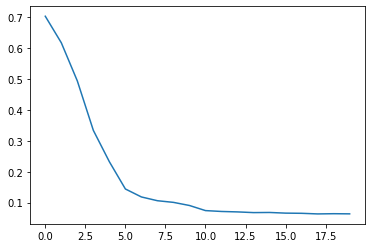

In [0]:
plt.plot(range(0, len(loss_history)), loss_history)

In [0]:

def compute_roc_auc(model, loader):
  """
  Computes accuracy on the dataset wrapped in a loader

  Returns: false positive
  """
  model.eval() # Evaluation mode
  roc_auc = 0.0
  n = 0
  y_pred = []
  y_true = []
  for x, y  in loader:
    x_device = x.to(device)
    y_device = y.to(device)
    preds = model(x_device)
    y_pred = np.concatenate((y_pred,preds.argmax(1).cpu().numpy()))
    y_true = np.concatenate((y_true,y_device.cpu().detach().numpy()))
  roc_auc += roc_auc_score(y_pred,y_true)
  return roc_auc


In [0]:
final_test_accuracy = compute_accuracy(model, testloader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  tensor(0.9326, device='cuda:0')


In [0]:
final_test_roc_auc = compute_roc_auc(model, testloader)
print("Final test roc_auc - ", final_test_roc_auc)

Final test roc_auc -  0.9324938194572466


In [0]:
print(sum(y_test == 1))

447


In [0]:
def cel(predt, y):
  return 'Cross entropy loss', loss(predt,y)

In [0]:
from xgboost import XGBClassifier 
import xgboost as xgb
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=[(X_train,y_train), (X_valid, y_valid)])

[0]	validation_0-error:0.342052	validation_0-logloss:0.680205	validation_1-error:0.402174	validation_1-logloss:0.684141
[1]	validation_0-error:0.322351	validation_0-logloss:0.669394	validation_1-error:0.38587	validation_1-logloss:0.676524
[2]	validation_0-error:0.266644	validation_0-logloss:0.657362	validation_1-error:0.34375	validation_1-logloss:0.66629
[3]	validation_0-error:0.251698	validation_0-logloss:0.647101	validation_1-error:0.32337	validation_1-logloss:0.657393
[4]	validation_0-error:0.258152	validation_0-logloss:0.638193	validation_1-error:0.320652	validation_1-logloss:0.652183
[5]	validation_0-error:0.246603	validation_0-logloss:0.628181	validation_1-error:0.326087	validation_1-logloss:0.644757
[6]	validation_0-error:0.220109	validation_0-logloss:0.618513	validation_1-error:0.298913	validation_1-logloss:0.636488
[7]	validation_0-error:0.225204	validation_0-logloss:0.610306	validation_1-error:0.304348	validation_1-logloss:0.630467
[8]	validation_0-error:0.219429	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
print("Accuracy: ", accuracy_score(y_test, xgbc.predict_proba(X_test)[:,1] > 0.5))

Accuracy:  0.7576086956521739


In [0]:
final_test_accuracy = compute_accuracy(model, testloader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  tensor(0.9326, device='cuda:0')


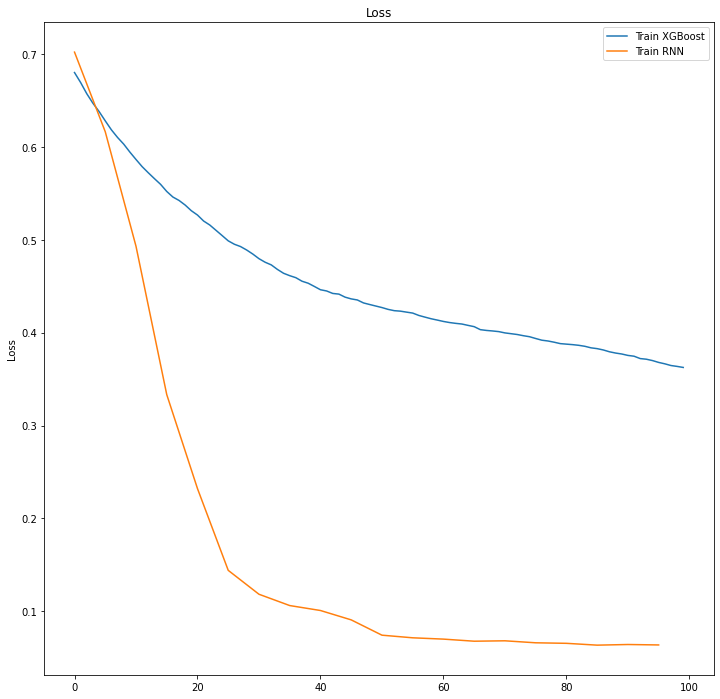

In [0]:
results = xgbc.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
x_axis2 = range(0,100,int(100/len(loss_history)))

# plot log loss
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train XGBoost')
# ax.plot(x_axis, results['validation_1']['logloss'], label='Valid XGBoost')
ax.plot(x_axis2 , loss_history, label='Train RNN')
ax.legend()

plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [0]:
[results['validation_0']['logloss'][i] for i in range(0,100,5)]

[0.680205,
 0.628181,
 0.58659,
 0.552159,
 0.526753,
 0.498978,
 0.479778,
 0.461471,
 0.44632,
 0.436475,
 0.427146,
 0.421201,
 0.412182,
 0.406572,
 0.399851,
 0.393824,
 0.387752,
 0.382901,
 0.375611,
 0.368068]

In [0]:
loss_history


[0.7021867632865906,
 0.6164534687995911,
 0.49315783381462097,
 0.3334432542324066,
 0.2321852594614029,
 0.14416389167308807,
 0.1184261217713356,
 0.10625623911619186,
 0.10092475265264511,
 0.09083963185548782,
 0.0743560940027237,
 0.0715319812297821,
 0.07012005895376205,
 0.0678691565990448,
 0.06830286234617233,
 0.06616076827049255,
 0.06558665633201599,
 0.06362289190292358,
 0.06431199610233307,
 0.06383964419364929]